In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import math
import os

from sklearn import metrics, model_selection
from sklearn.preprocessing import scale, normalize
from sklearn import datasets, cluster
from sklearn import neighbors, ensemble, tree, linear_model
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

from hydra import initialize, compose

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    BatchNormalization,
    Concatenate,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    Input,
    Lambda,
    Softmax,
)

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0:1], 'GPU')

In [4]:
tf.config.experimental.set_virtual_device_configuration( 
    physical_devices[0], 
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)] )

### Locate and choose config files

In [5]:
initialize('../src/conf/') # Assume the configuration file is in the current folder

hydra.initialize()

In [51]:
cfg = compose(config_name='train.yaml')

In [7]:
cfg.keys()

dict_keys(['project', 'segmentation_base_path', 'preprocessed_image_base_path', 'fourier_base_path', 'brixia_score_base_path', 'raw_output_base', 'img_size', 'backbone', 'last_dense_size', 'batch_size', 'epochs', 'learning_rate', 'steps_per_epoch', 'death_rate', 'visualize', 'augment', 'cross_val_train', 'fold', 'n_folds', 'dataset_identifier', 'datasets'])

#### paths for image based models

In [8]:
cfg.preprocessed_image_base_path, cfg.fourier_base_path, cfg.segmentation_base_path

('/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/aligned',
 '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/fourier_2d',
 '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/segmented')

#### paths for dataframe based models

In [9]:
cfg.brixia_score_base_path

'/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/score_original'

In [10]:
cfg.datasets.keys()

dict_keys(['population_average', 'population_sampled', 'age_average', 'hospital_average'])

In [11]:
cfg.datasets.population_average.keys()

dict_keys(['train_table', 'valid_table', 'test_table', 'cv_train_table', 'cv_valid_table', 'feature_cols'])

##### read raw dataframe for future use if needed

In [12]:
whole_df = pd.read_excel('/mnt/ncshare/ai4covid_hackathon/raw_data/trainClinData.xls' )
raw_df = whole_df[ ['ImageFile', 'Prognosis'] ]
raw_df.Prognosis.replace('SEVERE', 1, inplace=True)
raw_df.Prognosis.replace('MILD', 0, inplace=True)
raw_df.head()

,ImageFile,Prognosis
0,P_102.png,1
1,P_131.png,0
2,P_132.png,0
3,P_117.png,0
4,P_16.png,1


##### how folds are encoded

In [13]:
cfg.datasets.population_average.cv_train_table, '+cv1.csv', '+cv2.csv', '...', '+cv5.csv'

('/mnt/ncshare/ai4covid_hackathon/preprocessed_data/tables/pop_avg/trainClinDataImputedPopAvg_',
 '+cv1.csv',
 '+cv2.csv',
 '...',
 '+cv5.csv')

In [14]:
cfg.datasets.population_average.cv_valid_table

'/mnt/ncshare/ai4covid_hackathon/preprocessed_data/tables/pop_avg/validClinDataImputedPopAvg_'

##### train cv1 and valid cv1 are the corresponding parts

In [15]:
np.in1d( pd.read_csv( cfg.datasets.population_average.cv_train_table+'cv1.csv').ImageFile.unique(), pd.read_csv( cfg.datasets.population_average.cv_valid_table+'cv1.csv').ImageFile.unique() ).sum()

0

##### dataframe colums

In [16]:
best_cols = np.array(['Age', 'BPCO', 'CRP', 'CardiovascularDisease', 'Cough', 'D_dimer', 'DaysFever', 'Diabetes', 'DifficultyInBreathing', 'Fibrinogen', 'Glucose', 'HighBloodPressure', 'Hospital_A', 'Hospital_C', 'Hospital_D', 'Hospital_F', 'INR', 'IschemicHeartDisease', 'LDH', 'Ox_percentage', 'PCT', 'PaCO2', 'PaO2', 'Position', 'RBC', 'SaO2', 'Sex', 'Temp_C', 'WBC', 'pH'])

In [17]:
best_cols.shape

(30,)

In [18]:
np.array(cfg.datasets.population_average.feature_cols)[ np.in1d(cfg.datasets.population_average.feature_cols, best_cols) ]

array(['Age', 'Sex', 'Temp_C', 'DaysFever', 'Cough',
       'DifficultyInBreathing', 'WBC', 'RBC', 'CRP', 'Fibrinogen',
       'Glucose', 'PCT', 'LDH', 'INR', 'D_dimer', 'Ox_percentage', 'PaO2',
       'SaO2', 'PaCO2', 'pH', 'CardiovascularDisease',
       'IschemicHeartDisease', 'HighBloodPressure', 'Diabetes', 'BPCO',
       'Position', 'Hospital_A', 'Hospital_C', 'Hospital_D', 'Hospital_F'],
      dtype='<U21')

## Table based models

### Data preprocessing

In [19]:
def dataframe_preproc( df, columns=[] ):
    df.Prognosis.replace('SEVERE', 1, inplace=True)
    df.Prognosis.replace('MILD', 0, inplace=True)
    X_df = df.drop( columns=['ImageFile', 'Prognosis', 'Death'])    
    
    y = df[ ['Prognosis', 'Death'] ].values
        
    if len(columns) > 0:
        X_df = X_df[best_cols] # restrict to certain columns only
    
    X = X_df.values
    X_features = X_df.columns
        
    return X, y, X_features

In [20]:
def load_cv_data( cv=1, dataset='population_average', columns=[], include_death_column=False ):
    train_cv_df = pd.read_csv( cfg.datasets[dataset].cv_train_table+'cv'+str(cv)+'.csv')
    valid_cv_df = pd.read_csv( cfg.datasets[dataset].cv_valid_table+'cv'+str(cv)+'.csv')

    x_train, y_train, features_train = dataframe_preproc( train_cv_df, columns )
    x_valid, y_valid, features_valid = dataframe_preproc( valid_cv_df, columns )

    if include_death_column:
         return x_train, y_train, x_valid, y_valid
        
    else:
        # keep prognosis only
        y_train = y_train[:,0]
        y_valid = y_valid[:,0]

        #print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)
        return x_train, y_train, x_valid, y_valid    

In [21]:
x_train, y_train, x_valid, y_valid = load_cv_data(1, 'population_average', columns=best_cols)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(882, 30) (882,) (221, 30) (221,)


### Sklearn models

In [22]:
def five_fold_cv_model_eval( model, dataset='population_average', columns=[]):
    try:
        model_instance = model(n_jobs=8)
    except:
        model_instance = model()
        
    b_accs = []
    roc_aucs = []
    f1s = []
    
    scores = {}
    
    for f in range(1,6):
        x_train, y_train, x_valid, y_valid = load_cv_data(f, dataset, columns)
        model_instance.fit(x_train, y_train)
        try:
            pred_values_label = model_instance.predict(x_valid)
            b_acc = metrics.balanced_accuracy_score( y_pred=pred_values_label, y_true=y_valid )
            f1 = metrics.f1_score( y_true=y_valid, y_pred=pred_values_label )
            f1s.append(f1)
            b_accs.append(b_acc)
        except:
            print('', end='\r')
        
        try:
            pred_values_proba = model_instance.predict_proba(x_valid)            
            roc_auc = metrics.roc_auc_score( y_true=y_valid, y_score=pred_values_proba[:,1] )
            roc_aucs.append(roc_auc)
            
        except:
            try:
                # this is added for SVM proba pred
                model_instance = model(probability=True)
                model_instance.fit(x_train, y_train)
                pred_values_proba = model_instance.predict_proba(x_valid)
                roc_auc = metrics.roc_auc_score( y_true=y_valid, y_score=pred_values_proba[:,1] )
                roc_aucs.append(roc_auc)
            except:
                print('', end='\r')
    
    scores['balanced_accuracy'] = b_accs
    scores['roc_auc'] = roc_aucs
    scores['f1'] = f1s
    
    return scores

#### Define models

In [23]:
models_to_run = { 'Logistic': linear_model.LogisticRegression, 'SVM': svm.SVC, 
                  'Randomforest': ensemble.RandomForestClassifier, 'GradientBoosting': ensemble.GradientBoostingClassifier,
                  'XGB': XGBClassifier}
models_to_run

{'Logistic': sklearn.linear_model._logistic.LogisticRegression,
 'SVM': sklearn.svm._classes.SVC,
 'Randomforest': sklearn.ensemble._forest.RandomForestClassifier,
 'GradientBoosting': sklearn.ensemble._gb.GradientBoostingClassifier,
 'XGB': xgboost.sklearn.XGBClassifier}

In [24]:
num_to_model = dict( zip( np.arange(len(models_to_run)), list(models_to_run.keys()) ) )
num_to_model

{0: 'Logistic', 1: 'SVM', 2: 'Randomforest', 3: 'GradientBoosting', 4: 'XGB'}

In [25]:
def legend_without_duplicate_labels(ax):
    # https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib/40870637
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), prop={'size': 22}, loc='lower right')

In [26]:
def fit_and_eval_models( num_to_model, models_to_run, fig, dataset='population_average', color='blue', m='o', shift=0, columns=[]):
    all_scores = { model : None for num, model in num_to_model.items() }
    for i in range( len(num_to_model) ):
        current_model = num_to_model[i] 
        #print(current_model)
        scores = five_fold_cv_model_eval( models_to_run[current_model], dataset, columns )

        ax1 = plt.subplot(131)
        value = np.mean( scores['balanced_accuracy'] )
        std_err = np.std( scores['balanced_accuracy'] ) / np.sqrt(5)
        #sc = plt.scatter( i+np.zeros(5)+shift, scores['balanced_accuracy'], label=current_model, c=color, marker=m)
        sc = plt.errorbar( i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        #plt.xlabel('Models')
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45, size=25)
        plt.ylabel('Balanced accuracy score', size=30)
        plt.grid(True)
        sc.set_label(dataset)
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax1)        

        ax2 = plt.subplot(132)
        value = np.mean( scores['roc_auc'] )
        std_err = np.std( scores['roc_auc'] ) / np.sqrt(5)
        #sc = plt.scatter( i+np.zeros(5)+shift, scores['roc_auc'], label=current_model, c=color, marker=m)
        sc = plt.errorbar( i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        #plt.xlabel('Models')
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45, size=25)
        plt.ylabel('Roc auc score', size=30)
        plt.grid(True)
        sc.set_label(dataset)
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax2)        

        ax3 = plt.subplot(133)
        value = np.mean( scores['f1'] )
        std_err = np.std( scores['f1'] ) / np.sqrt(5)
        
        #sc = plt.scatter( i+np.zeros(5)+shift, scores['f1'], label=current_model, c=color, marker=m)
        sc = plt.errorbar( i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        #plt.xlabel('Models')
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45, size=25)
        plt.ylabel('F1 score', size=30)
        plt.grid(True)
        sc.set_label(dataset)
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax3)
            
        all_scores[current_model] = scores
    return all_scores

[16:25:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

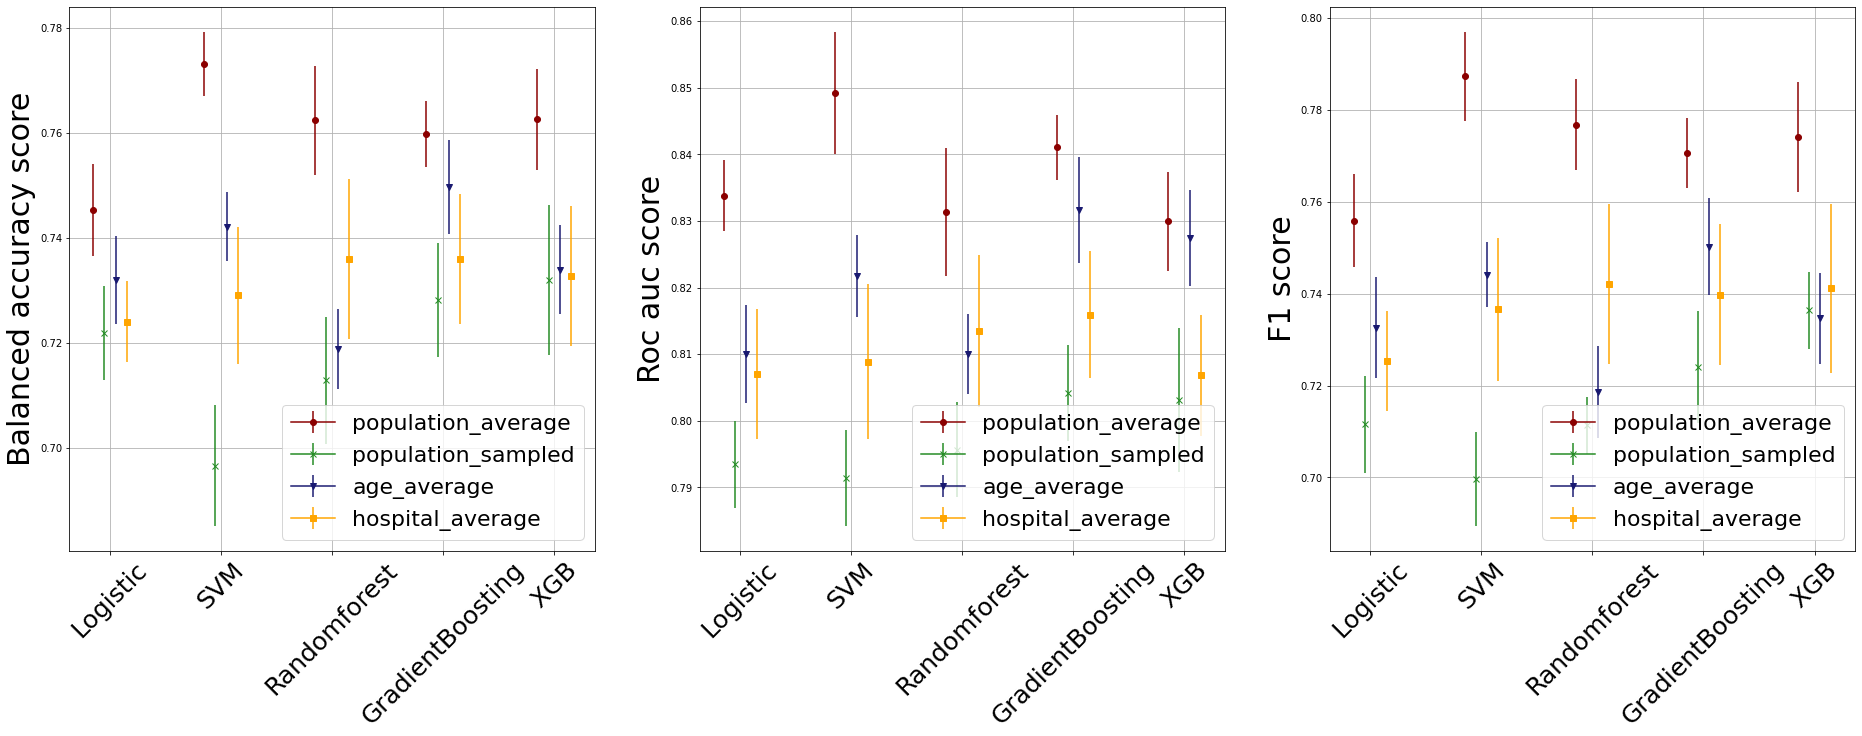

In [27]:
fig = plt.figure( figsize=(32, 10) )
pop_avg_scores = fit_and_eval_models( num_to_model, models_to_run, fig, dataset='population_average', color='darkred', m='o', shift=-0.15)
pop_smp_scores = fit_and_eval_models( num_to_model, models_to_run, fig, dataset='population_sampled', color='forestgreen', m='x', shift=-0.05)
age_avg_scores = fit_and_eval_models( num_to_model, models_to_run, fig, dataset='age_average', color='midnightblue', m='v', shift=0.05)
hsp_avg_scores = fit_and_eval_models( num_to_model, models_to_run, fig, dataset='hospital_average', color='orange', m='s', shift=0.15)

In [28]:
print('Population average')
for model, scores in pop_avg_scores.items():
    print(f'{model} BA :', np.mean(scores['balanced_accuracy']), np.std(scores['balanced_accuracy']))
    print(f'{model} F1 :', np.mean(scores['f1']), np.std(scores['f1']))
    print(f'{model} AUC :', np.mean(scores['roc_auc']), np.std(scores['roc_auc']))

Population average
Logistic BA : 0.7453236652045537 0.019473255713757794
Logistic F1 : 0.7558565005230309 0.0226297794191152
Logistic AUC : 0.8338248366622251 0.011957251138338074
SVM BA : 0.77314672326306 0.013610996485339555
SVM F1 : 0.7873114399671408 0.02179372219611529
SVM AUC : 0.8492608474405682 0.02048611665128492
Randomforest BA : 0.7623334066662302 0.023294047431648132
Randomforest F1 : 0.7768489841201031 0.02191802778872716
Randomforest AUC : 0.8313203212057427 0.021518642081777565
GradientBoosting BA : 0.759753644977638 0.014061595893623335
GradientBoosting F1 : 0.7706309790999135 0.017204478710051516
GradientBoosting AUC : 0.8410718543139832 0.010839504761431648
XGB BA : 0.7625471633020695 0.02152421361224836
XGB F1 : 0.7741565584613056 0.026886209672727635
XGB AUC : 0.8299548589571764 0.016586226676050832


In [29]:
print('Population sampling')
for model, scores in pop_smp_scores.items():
    print(f'{model} BA :', np.mean(scores['balanced_accuracy']), np.std(scores['balanced_accuracy']))
    print(f'{model} F1 :', np.mean(scores['f1']), np.std(scores['f1']))
    print(f'{model} AUC :', np.mean(scores['roc_auc']), np.std(scores['roc_auc']))

Population sampling
Logistic BA : 0.7218666367877036 0.01997506848709735
Logistic F1 : 0.7115613172468913 0.023726215674685254
Logistic AUC : 0.7934498888503903 0.014680842748712114
SVM BA : 0.6966311104387884 0.02570322936689327
SVM F1 : 0.6996515476023673 0.02280148583415954
SVM AUC : 0.7914028273779846 0.016045830147645167
Randomforest BA : 0.7128549656304709 0.027159096001867576
Randomforest F1 : 0.7113942102125731 0.01382051307532692
Randomforest AUC : 0.7956756764205977 0.016012218813224212
GradientBoosting BA : 0.7281443379605615 0.024323775192590696
GradientBoosting F1 : 0.7239644963317311 0.027304706512908516
GradientBoosting AUC : 0.8041634642865345 0.01623947686042039
XGB BA : 0.7319987553953752 0.03194513493570612
XGB F1 : 0.7363607937049326 0.01885016091777922
XGB AUC : 0.8031838896801157 0.02413839196571323


In [30]:
print('Age average')
for model, scores in age_avg_scores.items():
    print(f'{model} BA :', np.mean(scores['balanced_accuracy']), np.std(scores['balanced_accuracy']))
    print(f'{model} F1 :', np.mean(scores['f1']), np.std(scores['f1']))
    print(f'{model} AUC :', np.mean(scores['roc_auc']), np.std(scores['roc_auc']))

Age average
Logistic BA : 0.7319454257919674 0.01858471526781337
Logistic F1 : 0.7326310413926231 0.024484863825223368
Logistic AUC : 0.8100539761250332 0.016505246714010647
SVM BA : 0.7421233885637268 0.014522313618599526
SVM F1 : 0.7441562403193893 0.015874681679657547
SVM AUC : 0.8217246934605871 0.0138082989845548
Randomforest BA : 0.718850582627192 0.017119700376546924
Randomforest F1 : 0.7185738303185543 0.022459070760776478
Randomforest AUC : 0.8100335416103462 0.013495009656913632
GradientBoosting BA : 0.7496712822343365 0.019913133888075765
GradientBoosting F1 : 0.7502686210607252 0.023460088714542325
GradientBoosting AUC : 0.8317104611505497 0.017819328030552913
XGB BA : 0.7339119112214672 0.018915240577101148
XGB F1 : 0.7346525574857885 0.022132115398437333
XGB AUC : 0.8274671397147586 0.016115598066399266


In [31]:
print('Hospital average')
for model, scores in hsp_avg_scores.items():
    print(f'{model} BA :', np.mean(scores['balanced_accuracy']), np.std(scores['balanced_accuracy']))
    print(f'{model} F1 :', np.mean(scores['f1']), np.std(scores['f1']))
    print(f'{model} AUC :', np.mean(scores['roc_auc']), np.std(scores['roc_auc']))

Hospital average
Logistic BA : 0.7240047515252186 0.017294852290970036
Logistic F1 : 0.7253668903154937 0.024179287552631826
Logistic AUC : 0.8070205343150771 0.021922325187596518
SVM BA : 0.7290240445612678 0.02917500238817727
SVM F1 : 0.7366357487922706 0.03488677499392187
SVM AUC : 0.8088997664649529 0.025888202109872197
Randomforest BA : 0.7358781651860301 0.03401855096017168
Randomforest F1 : 0.7421249605737292 0.03902101985046945
Randomforest AUC : 0.8134958761170358 0.025455383958532588
GradientBoosting BA : 0.7359749778414707 0.02760124002937288
GradientBoosting F1 : 0.7398282944844434 0.03438076934147814
GradientBoosting AUC : 0.8159308961591816 0.02140340177789323
XGB BA : 0.7327137481639674 0.029639127444158208
XGB F1 : 0.7411866113645056 0.04124239803244033
XGB AUC : 0.8068563309040366 0.020307306912058672


##### only best features

In [32]:
best_cols, best_cols.shape

(array(['Age', 'BPCO', 'CRP', 'CardiovascularDisease', 'Cough', 'D_dimer',
        'DaysFever', 'Diabetes', 'DifficultyInBreathing', 'Fibrinogen',
        'Glucose', 'HighBloodPressure', 'Hospital_A', 'Hospital_C',
        'Hospital_D', 'Hospital_F', 'INR', 'IschemicHeartDisease', 'LDH',
        'Ox_percentage', 'PCT', 'PaCO2', 'PaO2', 'Position', 'RBC', 'SaO2',
        'Sex', 'Temp_C', 'WBC', 'pH'], dtype='<U21'),
 (30,))

[16:26:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

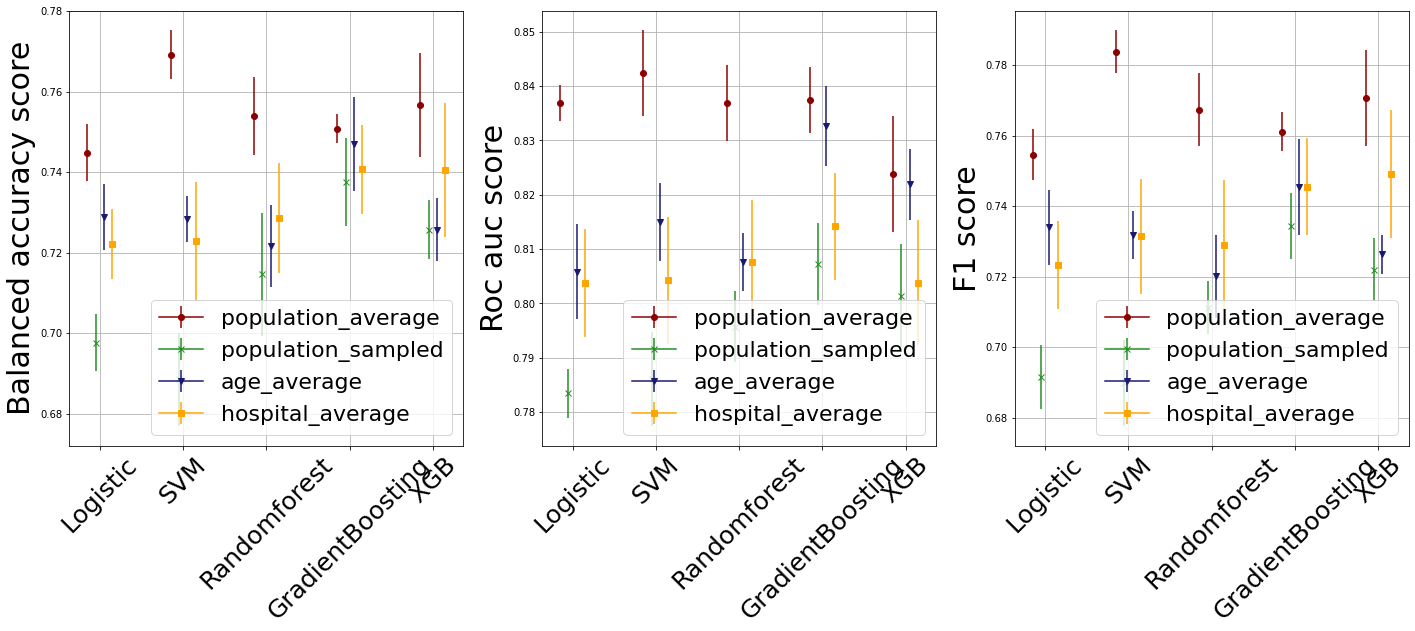

In [33]:
fig = plt.figure( figsize=(24,8) )
best_pop_avg_scores = fit_and_eval_models( num_to_model, models_to_run, fig, dataset='population_average', color='darkred', m='o', shift=-0.15, columns=best_cols)
best_pop_smp_scores = fit_and_eval_models( num_to_model, models_to_run, fig, dataset='population_sampled', color='forestgreen', m='x', shift=-0.05, columns=best_cols)
best_age_avg_scores = fit_and_eval_models( num_to_model, models_to_run, fig, dataset='age_average', color='midnightblue', m='v', shift=0.05, columns=best_cols)
best_hsp_avg_scores = fit_and_eval_models( num_to_model, models_to_run, fig, dataset='hospital_average', color='orange', m='s', shift=0.15, columns=best_cols)

## Simple neural networks

In [34]:
cfg.preprocessed_image_base_path, cfg.fourier_base_path, cfg.segmentation_base_path

('/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/aligned',
 '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/fourier_2d',
 '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/segmented')

In [35]:
x_train, y_train, x_valid, y_valid = load_cv_data(1, 'population_average', columns=best_cols, include_death_column=True)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((882, 30), (882, 2), (221, 30), (221, 2))

In [36]:
cfg.batch_size, cfg.epochs

(7, 36)

In [37]:
def five_fold_cv_model_eval_NN( model, dataset='population_average', batch_size=8, columns=[]  ):
        
    b_accs = []
    roc_aucs = []
    f1s = []
    
    scores = {}
    
    for f in range(1,6):
        #print(columns)
        x_train, y_train, x_valid, y_valid = load_cv_data(f, dataset, columns, include_death_column=True)
        #print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)
        model_instance, early_stopping = model(x_train.shape[1]) # init with feature
        
        
        try:
            history = model_instance.fit( x=x_train, y=[ tf.keras.utils.to_categorical(y_train[:,0]), tf.keras.utils.to_categorical(y_train[:,1]) ],
                            validation_data=( x_valid, [ tf.keras.utils.to_categorical(y_valid[:,0]), tf.keras.utils.to_categorical(y_valid[:,1]) ] ),
                            epochs=cfg.epochs,
                            callbacks=[early_stopping],
                            verbose=0,
                            batch_size=batch_size
                            )
            prognosis_pred, death_pred = model_instance.predict( x_valid )
        
            prognosis_pred_labels = np.argmax( prognosis_pred, axis=-1)
            prognosis_pred_proba = prognosis_pred[:,1]
            #print(prognosis_pred_labels.shape, prognosis_pred_labels[:5], y_valid[:5])
            
        except:
            history = model_instance.fit( x=x_train, y=[ tf.keras.utils.to_categorical(y_train[:,0]) ],
                            validation_data=( x_valid, [ tf.keras.utils.to_categorical(y_valid[:,0]) ] ),
                            epochs=cfg.epochs,
                            callbacks=[early_stopping],
                            verbose=0,
                            )
            prognosis_pred = model_instance.predict( x_valid )
        
            prognosis_pred_labels = np.argmax( prognosis_pred, axis=-1)
            prognosis_pred_proba = prognosis_pred[:,1]
            #print(prognosis_pred_labels.shape, prognosis_pred_labels[:5], y_valid[:5])
        
        try:
            b_acc = metrics.balanced_accuracy_score( y_pred=prognosis_pred_labels, y_true=y_valid[:,0] )
            f1 = metrics.f1_score( y_true=y_valid[:,0], y_pred=prognosis_pred_labels )
            f1s.append(f1)
            b_accs.append(b_acc)
        except:
            print('', end='\r')
        
        try:
            roc_auc = metrics.roc_auc_score( y_true=y_valid[:,0], y_score=prognosis_pred_proba )
            roc_aucs.append(roc_auc)
            
        except:
            print('', end='\r')
    
    scores['balanced_accuracy'] = b_accs
    scores['roc_auc'] = roc_aucs
    scores['f1'] = f1s
    
    return scores

In [38]:
def meta_model( n_feature_cols ):
    input_meta = Input(shape=(n_feature_cols), name="meta", dtype="float32")
    death = Input(name="death", shape=(2), dtype="int32")
    prognosis = Input(name="prognosis", shape=(2), dtype="int32")

    ## META HEAD
    meta = Dense(64, activation="relu")(input_meta)
    meta = BatchNormalization(name="meta_bn1")(meta)
    meta = Dense(128, activation="relu")(meta)
    meta = BatchNormalization(name="meta_bn2")(meta)
    meta = Dense(128, activation="relu")(meta)
    meta_out = BatchNormalization(name="meta_bn3")(meta)

    out = Dense(256, activation="relu")(meta_out)
    out = BatchNormalization(name="head_bn1")(out)
    out = Dropout(0.2)(meta)
    out = Dense(cfg.last_dense_size, activation="relu")(out)
    out = BatchNormalization(name="head_bn2")(out)
    out = Dense(4, activation="linear", name="unnormalized_output")(out)

    p, d = Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=1), name="outputs")(
        out
    )
    prognosis_out = Softmax(name="prognosis_out")(p)
    death_out = Softmax(name="death_out")(d)

    model = keras.models.Model(
        inputs=[ input_meta ],
        outputs=[prognosis_out, death_out],
        name="model_v1",
    )

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        cfg.learning_rate,
        decay_steps=3 * cfg.steps_per_epoch,
        decay_rate=0.15,
        staircase=False,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=5,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )

    opt = keras.optimizers.Adam(lr_schedule)
    model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy)

    #model.summary()

    #prognosis_out = BinaryEndpointLayer(name="prognosis_binary_loss", config=config)(
    #    prognosis, p
    #)
    #death_out = BinaryEndpointLayer(name="death_binary_loss", config=config)(death, d)
    return model, early_stopping

In [39]:
def meta_model_mod( n_feature_cols ):
    input_meta = Input(shape=(n_feature_cols), name="meta", dtype="float32")
    death = Input(name="death", shape=(2), dtype="int32")
    prognosis = Input(name="prognosis", shape=(2), dtype="int32")

    ## META HEAD
    meta = Dense(64, activation="relu")(input_meta)
    #meta = BatchNormalization(name="meta_bn1")(meta)
    meta = Dense(64, activation="relu")(meta)
    #meta = BatchNormalization(name="meta_bn2")(meta)
    #meta = Dense(128, activation="relu")(meta)
    #meta_out = BatchNormalization(name="meta_bn3")(meta)

    out = Dense(128, activation="relu")(meta)
    #out = BatchNormalization(name="head_bn1")(out)
    out = Dropout(0.2)(out)
    out = Dense(cfg.last_dense_size, activation="relu")(out)
    #out = BatchNormalization(name="head_bn2")(out)
    out = Dense(4, activation="linear", name="unnormalized_output")(out)

    p, d = Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=1), name="outputs")(
        out
    )
    prognosis_out = Softmax(name="prognosis_out")(p)
    death_out = Softmax(name="death_out")(d)

    model = keras.models.Model(
        inputs=[ input_meta ],
        outputs=[prognosis_out, death_out],
        name="model_v1",
    )

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        cfg.learning_rate,
        decay_steps=3 * cfg.steps_per_epoch,
        decay_rate=1e-2,
        staircase=False,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=15,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )

    opt = keras.optimizers.Adam(lr_schedule)
    model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy)

    #model.summary()

    #prognosis_out = BinaryEndpointLayer(name="prognosis_binary_loss", config=config)(
    #    prognosis, p
    #)
    #death_out = BinaryEndpointLayer(name="death_binary_loss", config=config)(death, d)
    return model, early_stopping

In [40]:
def meta_model_mod2( n_feature_cols ):
    input_meta = Input(shape=(n_feature_cols), name="meta", dtype="float32")
    death = Input(name="death", shape=(2), dtype="int32")
    prognosis = Input(name="prognosis", shape=(2), dtype="int32")

    ## META HEAD
    meta = Dense(64, activation="tanh")(input_meta)
    #meta = BatchNormalization(name="meta_bn1")(meta)
    meta = Dense(64, activation="tanh")(meta)
    #meta = BatchNormalization(name="meta_bn2")(meta)
    #meta = Dense(128, activation="relu")(meta)
    #meta_out = BatchNormalization(name="meta_bn3")(meta)

    out = Dense(128, activation="tanh")(meta)
    #out = BatchNormalization(name="head_bn1")(out)
    out = Dropout(0.2)(out)
    out = Dense(cfg.last_dense_size, activation="tanh")(out)
    #out = BatchNormalization(name="head_bn2")(out)
    out = Dense(4, activation="linear", name="unnormalized_output")(out)

    p, d = Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=1), name="outputs")(
        out
    )
    prognosis_out = Softmax(name="prognosis_out")(p)
    death_out = Softmax(name="death_out")(d)

    model = keras.models.Model(
        inputs=[ input_meta ],
        outputs=[prognosis_out, death_out],
        name="model_v1",
    )

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        cfg.learning_rate,
        decay_steps=3 * cfg.steps_per_epoch,
        decay_rate=1e-2,
        staircase=False,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=15,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )

    opt = keras.optimizers.Adam(lr_schedule)
    model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy)

    #model.summary()

    #prognosis_out = BinaryEndpointLayer(name="prognosis_binary_loss", config=config)(
    #    prognosis, p
    #)
    #death_out = BinaryEndpointLayer(name="death_binary_loss", config=config)(death, d)
    return model, early_stopping

In [41]:
def meta_model_mod3( n_feature_cols ):
    input_meta = Input(shape=(n_feature_cols), name="meta", dtype="float32")
    death = Input(name="death", shape=(2), dtype="int32")
    prognosis = Input(name="prognosis", shape=(2), dtype="int32")

    ## META HEAD
    meta = Dense(64, activation="tanh")(input_meta)
    meta = BatchNormalization(name="meta_bn1")(meta)
    meta = Dense(64, activation="tanh")(meta)
    #meta = BatchNormalization(name="meta_bn2")(meta)
    #meta = Dense(128, activation="relu")(meta)
    #meta_out = BatchNormalization(name="meta_bn3")(meta)

    out = Dense(128, activation="tanh")(meta)
    #out = BatchNormalization(name="head_bn1")(out)
    out = Dropout(0.2)(out)
    out = Dense(cfg.last_dense_size, activation="tanh")(out)
    #out = BatchNormalization(name="head_bn2")(out)
    out = Dense(2, activation="linear", name="unnormalized_output")(out)

    #p, d = Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=1), name="outputs")(
    #    out
    #)
    prognosis_out = Softmax(name="prognosis_out")(out)
    #death_out = Softmax(name="death_out")(d)

    model = keras.models.Model(
        inputs=[ input_meta ],
        outputs=[ prognosis_out ],
        name="model_v1",
    )

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=3 * cfg.steps_per_epoch,
        decay_rate=1e-2,
        staircase=False,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=15,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )

    opt = keras.optimizers.Adam(lr_schedule)
    model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy)

    #model.summary()

    #prognosis_out = BinaryEndpointLayer(name="prognosis_binary_loss", config=config)(
    #    prognosis, p
    #)
    #death_out = BinaryEndpointLayer(name="death_binary_loss", config=config)(death, d)
    return model, early_stopping

In [42]:
def meta_model_mod4( n_feature_cols ):
    input_meta = Input(shape=(n_feature_cols), name="meta", dtype="float32")
    death = Input(name="death", shape=(2), dtype="int32")
    prognosis = Input(name="prognosis", shape=(2), dtype="int32")

    ## META HEAD
    meta = Dense(128, activation="tanh")(input_meta)
    meta = BatchNormalization(name="meta_bn1")(meta)
    meta = Dense(128, activation="tanh")(meta)
    #meta = BatchNormalization(name="meta_bn2")(meta)
    #meta = Dense(128, activation="relu")(meta)
    #meta_out = BatchNormalization(name="meta_bn3")(meta)

    out = Dense(128, activation="tanh")(meta)
    #out = BatchNormalization(name="head_bn1")(out)
    out = Dropout(0.2)(out)
    out = Dense(cfg.last_dense_size, activation="tanh")(out)
    #out = BatchNormalization(name="head_bn2")(out)
    out = Dense(2, activation="linear", name="unnormalized_output")(out)

    #p, d = Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=1), name="outputs")(
    #    out
    #)
    prognosis_out = Softmax(name="prognosis_out")(out)
    #death_out = Softmax(name="death_out")(d)

    model = keras.models.Model(
        inputs=[ input_meta ],
        outputs=[ prognosis_out ],
        name="model_v1",
    )

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        cfg.learning_rate,
        decay_steps=3 * cfg.steps_per_epoch,
        decay_rate=1e-2,
        staircase=False,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=15,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )

    opt = keras.optimizers.Adam(lr_schedule)
    model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy,  )

    #model.summary()

    #prognosis_out = BinaryEndpointLayer(name="prognosis_binary_loss", config=config)(
    #    prognosis, p
    #)
    #death_out = BinaryEndpointLayer(name="death_binary_loss", config=config)(death, d)
    return model, early_stopping

In [43]:
def meta_model_mod5( n_feature_cols ):
    input_meta = Input(shape=(n_feature_cols), name="meta", dtype="float32")
    death = Input(name="death", shape=(2), dtype="int32")
    prognosis = Input(name="prognosis", shape=(2), dtype="int32")

    ## META HEAD
    meta = Dense(128, activation="tanh")(input_meta)
    meta = BatchNormalization(name="meta_bn1")(meta)
    meta = Dense(128, activation="tanh")(meta)
    meta = BatchNormalization(name="meta_bn2")(meta)
    #meta = Dense(128, activation="relu")(meta)
    #meta_out = BatchNormalization(name="meta_bn3")(meta)

    out = Dense(128, activation="tanh")(meta)
    #out = BatchNormalization(name="head_bn1")(out)
    out = Dropout(0.2)(out)
    out = Dense(cfg.last_dense_size, activation="tanh")(out)
    #out = BatchNormalization(name="head_bn2")(out)
    out = Dense(2, activation="linear", name="unnormalized_output")(out)

    #p, d = Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=1), name="outputs")(
    #    out
    #)
    prognosis_out = Softmax(name="prognosis_out")(out)
    #death_out = Softmax(name="death_out")(d)

    model = keras.models.Model(
        inputs=[ input_meta ],
        outputs=[ prognosis_out ],
        name="model_v1",
    )

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        cfg.learning_rate,
        decay_steps=3 * cfg.steps_per_epoch,
        decay_rate=1e-2,
        staircase=False,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=15,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )

    opt = keras.optimizers.Adam(lr_schedule)
    model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy)

    #model.summary()

    #prognosis_out = BinaryEndpointLayer(name="prognosis_binary_loss", config=config)(
    #    prognosis, p
    #)
    #death_out = BinaryEndpointLayer(name="death_binary_loss", config=config)(death, d)
    return model, early_stopping

In [44]:
models_to_run_NN = { 
    'meta_base': meta_model, 
    'meta_base_mod': meta_model_mod,
    'meta_base_mod2': meta_model_mod2,
    'meta_base_mod3': meta_model_mod3,
    'meta_base_mod4': meta_model_mod4,
    'meta_base_mod5': meta_model_mod5
    }
num_to_model_NN = dict( zip( np.arange(len(models_to_run_NN)), list(models_to_run_NN.keys()) ) )

In [45]:
def fit_and_eval_models_NN( num_to_model, models_to_run, 
                            dataset='population_average', color='blue', m='o', start_idx=0, shift=0, columns=[], batch_size=cfg.batch_size):
    all_scores = { model : None for num, model in num_to_model.items() }
    for i in range(len(num_to_model) ):
        current_model = num_to_model[i] 
        print(current_model)
        scores = five_fold_cv_model_eval_NN( models_to_run[current_model], dataset, batch_size, columns )

        ax1 = plt.subplot(131)
        value = np.mean( scores['balanced_accuracy'] )
        std_err = np.std( scores['balanced_accuracy'] ) / np.sqrt(5)
        #sc = plt.scatter( i+np.zeros(5)+shift, scores['balanced_accuracy'], label=current_model, c=color, marker=m)
        sc = plt.errorbar( start_idx+i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        #plt.xlabel('Models')
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45, size=25)
        plt.ylabel('Balanced accuracy score', size=30)
        plt.grid(True)
        sc.set_label(dataset)
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax1)        

        ax2 = plt.subplot(132)
        value = np.mean( scores['roc_auc'] )
        std_err = np.std( scores['roc_auc'] ) / np.sqrt(5)
        #sc = plt.scatter( i+np.zeros(5)+shift, scores['roc_auc'], label=current_model, c=color, marker=m)
        sc = plt.errorbar( start_idx+i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        #plt.xlabel('Models')
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45, size=25)
        plt.ylabel('Roc auc score', size=30)
        plt.grid(True)
        sc.set_label(dataset)
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax2)        

        ax3 = plt.subplot(133)
        value = np.mean( scores['f1'] )
        std_err = np.std( scores['f1'] ) / np.sqrt(5)
        #sc = plt.scatter( i+np.zeros(5)+shift, scores['f1'], label=current_model, c=color, marker=m)
        sc = plt.errorbar( start_idx+i+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
        #plt.xlabel('Models')
        plt.xticks(ticks=list(num_to_model.keys()), labels=list(num_to_model.values()), rotation=45, size=25)
        plt.ylabel('F1 score', size=30)
        plt.grid(True)
        sc.set_label(dataset)
        if i == len(num_to_model)-1: # put legend at the last iteration to avoid duplicates
            legend_without_duplicate_labels(ax3)
            
        all_scores[current_model] = scores
        
    return all_scores

meta_base
meta_base_mod
meta_base_mod2
meta_base_mod3
meta_base_mod4
meta_base_mod5
meta_base
meta_base_mod
meta_base_mod2
meta_base_mod3
meta_base_mod4
meta_base_mod5
meta_base
meta_base_mod
meta_base_mod2
meta_base_mod3
meta_base_mod4
meta_base_mod5
meta_base
meta_base_mod
meta_base_mod2
meta_base_mod3
meta_base_mod4
meta_base_mod5


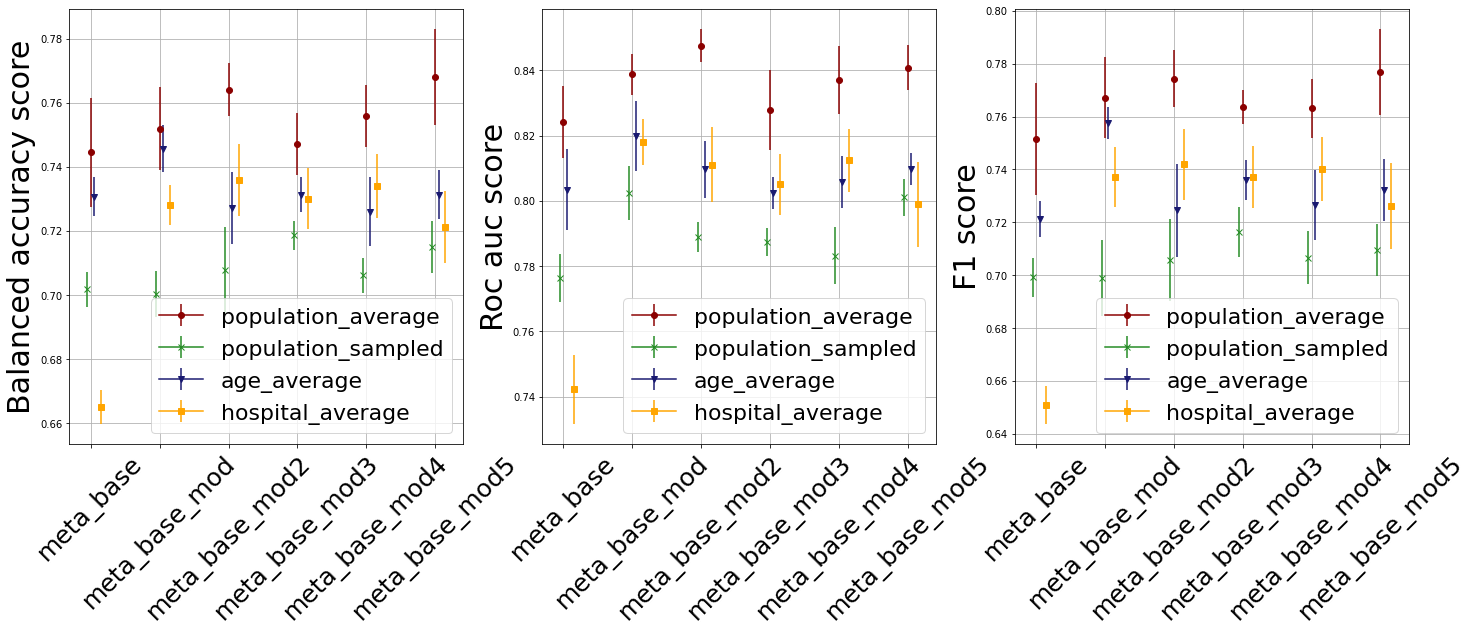

In [46]:
fig = plt.figure( figsize=(24,8) )
#fit_and_eval_models( num_to_model, models_to_run, fig, dataset='population_average', color='midnightblue', m='o', shift=0.0,)
nn_pop_avg_scores = fit_and_eval_models_NN( num_to_model_NN, models_to_run_NN, dataset='population_average', color='darkred', m='o', start_idx=0, shift=0.0)
nn_pop_smp_scores = fit_and_eval_models_NN( num_to_model_NN, models_to_run_NN, dataset='population_sampled', color='forestgreen', m='x', shift=-0.05)
nn_age_avg_scores = fit_and_eval_models_NN( num_to_model_NN, models_to_run_NN, dataset='age_average', color='midnightblue', m='v', shift=0.05)
nn_hsp_avg_scores = fit_and_eval_models_NN( num_to_model_NN, models_to_run_NN, dataset='hospital_average', color='orange', m='s', shift=0.15)

In [47]:
print('Population average')
for model, scores in nn_pop_avg_scores.items():
    print(f'{model} BA :', np.mean(scores['balanced_accuracy']), np.std(scores['balanced_accuracy']))
    print(f'{model} F1 :', np.mean(scores['f1']), np.std(scores['f1']))
    print(f'{model} AUC :', np.mean(scores['roc_auc']), np.std(scores['roc_auc']))

Population average
meta_base BA : 0.7445200799485624 0.03778060364397854
meta_base F1 : 0.7515607912936086 0.047589069981174514
meta_base AUC : 0.8240542190999485 0.024668060219948534
meta_base_mod BA : 0.7518786398781868 0.028914270650702015
meta_base_mod F1 : 0.7671591952166066 0.03435682414712247
meta_base_mod AUC : 0.8387665628070542 0.014082961160094621
meta_base_mod2 BA : 0.7640702191203232 0.01824596646029165
meta_base_mod2 F1 : 0.7743893514253886 0.023808846800797857
meta_base_mod2 AUC : 0.8476215196141832 0.011467580242059235
meta_base_mod3 BA : 0.7469788020798724 0.02160811789464627
meta_base_mod3 F1 : 0.7636715367082336 0.01425055027981037
meta_base_mod3 AUC : 0.8278927347224301 0.02741988883847045
meta_base_mod4 BA : 0.7558094132316648 0.02164389422078468
meta_base_mod4 F1 : 0.7630755765585262 0.025010729436669116
meta_base_mod4 AUC : 0.8371299830114971 0.02324619265316653
meta_base_mod5 BA : 0.7680480111293724 0.033519125642366664
meta_base_mod5 F1 : 0.7767942018283395 0.0

In [48]:
print('Population samples')
for model, scores in nn_pop_smp_scores.items():
    print(f'{model} BA :', np.mean(scores['balanced_accuracy']), np.std(scores['balanced_accuracy']))
    print(f'{model} F1 :', np.mean(scores['f1']), np.std(scores['f1']))
    print(f'{model} AUC :', np.mean(scores['roc_auc']), np.std(scores['roc_auc']))

Population samples
meta_base BA : 0.7019044932531797 0.012166625544963432
meta_base F1 : 0.6991890188664384 0.016178780031992294
meta_base AUC : 0.7763493478077454 0.016532341755535137
meta_base_mod BA : 0.7003977552050136 0.016031741789478415
meta_base_mod F1 : 0.6988735157300792 0.032342102472891175
meta_base_mod AUC : 0.8024259523556442 0.01839262157422627
meta_base_mod2 BA : 0.7079241396118636 0.02997281250496056
meta_base_mod2 F1 : 0.7057002220578342 0.034547515659186435
meta_base_mod2 AUC : 0.78899818464832 0.01042565589149967
meta_base_mod3 BA : 0.7186279211058195 0.01017523580908984
meta_base_mod3 F1 : 0.7163693515481294 0.020874888068715236
meta_base_mod3 AUC : 0.787413540258552 0.009326052232646242
meta_base_mod4 BA : 0.706167478002413 0.012381396631716059
meta_base_mod4 F1 : 0.7066517304883939 0.02234730217032958
meta_base_mod4 AUC : 0.7832271085219966 0.019713566855010682
meta_base_mod5 BA : 0.7149700958519507 0.017962711196234094
meta_base_mod5 F1 : 0.7095143227713397 0.02

In [49]:
print('Age average')
for model, scores in nn_age_avg_scores.items():
    print(f'{model} BA :', np.mean(scores['balanced_accuracy']), np.std(scores['balanced_accuracy']))
    print(f'{model} F1 :', np.mean(scores['f1']), np.std(scores['f1']))
    print(f'{model} AUC :', np.mean(scores['roc_auc']), np.std(scores['roc_auc']))

Age average
meta_base BA : 0.730698478243011 0.013499813449562244
meta_base F1 : 0.7214495640423534 0.015204350516430591
meta_base AUC : 0.803393709312602 0.02782075170623191
meta_base_mod BA : 0.7456744086452818 0.016211472077255564
meta_base_mod F1 : 0.7575743056394008 0.013577349924042718
meta_base_mod AUC : 0.8198578150158428 0.02410236927032436
meta_base_mod2 BA : 0.7271923281983455 0.02511017542815695
meta_base_mod2 F1 : 0.7244947604759033 0.03935632281140253
meta_base_mod2 AUC : 0.8096870302647783 0.01943353892666581
meta_base_mod3 BA : 0.7313781303222633 0.011933460891599702
meta_base_mod3 F1 : 0.7360215954897683 0.01730836092843041
meta_base_mod3 AUC : 0.8023893082324388 0.01105321630085373
meta_base_mod4 BA : 0.7259682676102288 0.024108386769738976
meta_base_mod4 F1 : 0.7265966184286252 0.029802922000951866
meta_base_mod4 AUC : 0.8058991067408726 0.017877472147215613
meta_base_mod5 BA : 0.7313479578317317 0.017203772096384205
meta_base_mod5 F1 : 0.7322224625008619 0.026551286

In [50]:
print('Hospital average')
for model, scores in nn_hsp_avg_scores.items():
    print(f'{model} BA :', np.mean(scores['balanced_accuracy']), np.std(scores['balanced_accuracy']))
    print(f'{model} F1 :', np.mean(scores['f1']), np.std(scores['f1']))
    print(f'{model} AUC :', np.mean(scores['roc_auc']), np.std(scores['roc_auc']))

Hospital average
meta_base BA : 0.6651165239016665 0.011923042824798417
meta_base F1 : 0.6508198303394809 0.01594005940462538
meta_base AUC : 0.742178188688498 0.02380149727725999
meta_base_mod BA : 0.7280342655416716 0.013871773423783092
meta_base_mod F1 : 0.7371321130328864 0.025124299305920604
meta_base_mod AUC : 0.8180785431495246 0.0156578996072657
meta_base_mod2 BA : 0.7358845718972867 0.025135720885770464
meta_base_mod2 F1 : 0.7419537104594915 0.029777247703624186
meta_base_mod2 AUC : 0.8111254675414432 0.02568959650026931
meta_base_mod3 BA : 0.730092804717336 0.02120833905498525
meta_base_mod3 F1 : 0.7370903980857008 0.02645500487827428
meta_base_mod3 AUC : 0.8051159382766716 0.020846176913076157
meta_base_mod4 BA : 0.7339737975462967 0.02216723059897531
meta_base_mod4 F1 : 0.740140628234613 0.02736029193127217
meta_base_mod4 AUC : 0.8123895771067872 0.021593487017267342
meta_base_mod5 BA : 0.7212041955980805 0.02502126656118948
meta_base_mod5 F1 : 0.7261242217267402 0.03652046

#### Locate data

In [51]:
def load_cv_data_pred_only( cv=1, dataset='age_average' ):
    
    base_path = os.path.join( cfg.raw_output_base, 'checkpoints' )
    model_cross_val_paths = np.array( sorted( [ i for i in os.listdir( base_path ) if 'CROSS' and 'v2' in i] ) )
    model_datasets = np.array([ '_'.join( j.split('_')[2:4]) for j in model_cross_val_paths ])
    cross_val_paths = model_cross_val_paths[ model_datasets == dataset ]
    
    current_fold_path = os.path.join( base_path, cross_val_paths[0] )
    model_checkpoint_dir = os.listdir( current_fold_path )
    
    current_final_path = os.path.join( current_fold_path, model_checkpoint_dir[cv-1] )+ '/pred.csv'
    
    pred_df = pd.read_csv(current_final_path)
    pred_df.prognosis.replace('SEVERE', 1, inplace=True)
    pred_df.prognosis.replace('MILD', 0, inplace=True)
    
    y_pred = pred_df.prognosis.values
    
    
    FOLD = int(open(os.path.join( current_fold_path, model_checkpoint_dir[cv-1], "fold"), 'r').readline()) + 1
    y_true = pd.read_csv( cfg.datasets[dataset].cv_valid_table+f'cv{FOLD}.csv')
    y_true.Prognosis.replace('SEVERE', 1, inplace=True)
    y_true.Prognosis.replace('MILD', 0, inplace=True)
    y_true = y_true.Prognosis.values
        
    return y_pred, y_true

In [52]:
def five_fold_cv_model_eval_NN_pred_only(dataset='age_average'):
        
    b_accs = []
    roc_aucs = []
    f1s = []
    
    scores = {}
    
    for f in range(1,6):
        #print(columns)
        y_pred, y_true = load_cv_data_pred_only(f, dataset)
        
        try:
            b_acc = metrics.balanced_accuracy_score( y_pred=y_pred, y_true=y_true )
            f1 = metrics.f1_score( y_true=y_true, y_pred=y_pred )
            f1s.append(f1)
            b_accs.append(b_acc)
        except:
            print('', end='\r')
        
        try:
            roc_auc = metrics.roc_auc_score( y_true=y_true, y_score=y_pred )
            roc_aucs.append(roc_auc)
            
        except:
            print('', end='\r')
    
    scores['balanced_accuracy'] = b_accs
    scores['roc_auc'] = roc_aucs
    scores['f1'] = f1s
    
    return scores

In [53]:
scores_age_avg = five_fold_cv_model_eval_NN_pred_only('age_average')

['CROSS_VAL_age_average_v2' 'CROSS_VAL_population_average_v2']
['CROSS_VAL_age_average_v2' 'CROSS_VAL_population_average_v2']
['CROSS_VAL_age_average_v2' 'CROSS_VAL_population_average_v2']
['CROSS_VAL_age_average_v2' 'CROSS_VAL_population_average_v2']
['CROSS_VAL_age_average_v2' 'CROSS_VAL_population_average_v2']


In [50]:
scores_age_avg

{'balanced_accuracy': [0.7550492610837438,
  0.7209972025670561,
  0.7555309734513274,
  0.7647902327105867,
  0.7095425479586817],
 'roc_auc': [0.7550492610837438,
  0.7209972025670561,
  0.7555309734513274,
  0.7647902327105867,
  0.7095425479586819],
 'f1': [0.7672413793103448,
  0.7822878228782287,
  0.7610619469026548,
  0.7614678899082569,
  0.6952380952380953]}

In [43]:
scores_pop_avg = five_fold_cv_model_eval_NN_pred_only('population_average')

In [44]:
scores_pop_avg

{'balanced_accuracy': [0.781900826446281,
  0.6900197465854863,
  0.7665598290598291,
  0.7265240904621435,
  0.7734349393641429],
 'roc_auc': [0.781900826446281,
  0.6900197465854863,
  0.7665598290598291,
  0.7265240904621435,
  0.773434939364143],
 'f1': [0.7860262008733625,
  0.7703180212014133,
  0.7678571428571429,
  0.696969696969697,
  0.7807017543859648]}

In [45]:
def plot_scores(scores, current_model, color, m, dataset, shift):
    ax1 = plt.subplot(131)
    value = np.mean( scores['balanced_accuracy'] )
    std_err = np.std( scores['balanced_accuracy'] ) / np.sqrt(5)
    sc = plt.errorbar( 5+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
    plt.ylabel('Balanced accuracy score')
    plt.grid(True)
    sc.set_label(dataset)  

    ax2 = plt.subplot(132)
    value = np.mean( scores['roc_auc'] )
    std_err = np.std( scores['roc_auc'] ) / np.sqrt(5)
    sc = plt.errorbar( 5+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
    plt.ylabel('Roc auc score')
    plt.grid(True)
    sc.set_label(dataset)       

    ax3 = plt.subplot(133)
    value = np.mean( scores['f1'] )
    std_err = np.std( scores['f1'] ) / np.sqrt(5)
    sc = plt.errorbar( 5+shift, value, yerr=std_err, label=current_model, c=color, marker=m )
    plt.ylabel('F1 score')
    plt.grid(True)
    sc.set_label(dataset)

[14:51:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

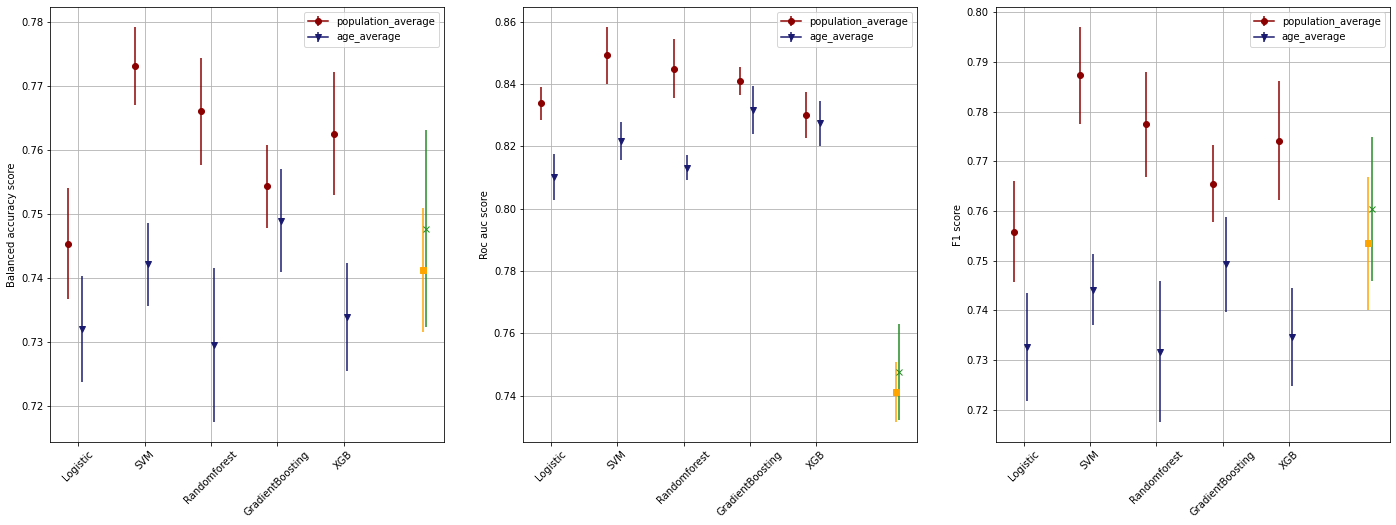

In [46]:
fig = plt.figure( figsize=(24,8) )
fit_and_eval_models( num_to_model, models_to_run, fig, dataset='population_average', color='darkred', m='o', shift=-0.15)
#fit_and_eval_models( num_to_model, models_to_run, fig, dataset='population_sampled', color='forestgreen', m='x', shift=-0.05)
fit_and_eval_models( num_to_model, models_to_run, fig, dataset='age_average', color='midnightblue', m='v', shift=0.05)
#fit_and_eval_models( num_to_model, models_to_run, fig, dataset='hospital_average', color='orange', m='s', shift=0.15)
plot_scores(scores_age_avg, 'Hybrid NN', color='orange', m='s', dataset='hybrid age_avg', shift=.2)
plot_scores(scores_pop_avg, 'Hybrid NN', color='forestgreen', m='x', dataset='hybrid pop_avg', shift=.25)